In [ ]:
!pip install pandas tensorflow alpha_vantage pandas-ta matplotlib sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install alpha_vantage

  Using cached alpha_vantage-3.0.0-py3-none-any.whl.metadata (12 kB)


In [ ]:
!pip install pandas-ta

  Using cached pandas_ta-0.3.14b.tar.gz (115 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=6d08b84bad56d46fdf98df9575f82242b142fce3fd391d65208831f64641f31a
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


Get daily data for a specific ticker for the past 20 years from alpha vantage. I chose daily data to avoid api limits, and i will add technical indicators via pandas-ta later.

I chose to use Alpha Vantage over yfinance because of stability for longer periods. I had some issues getting more than 5 years from yfinance. I chose Apple's stock price as an example.

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

# Set your API key
api_key = 'AWUBWW71DWE5KISU'

# Fetch daily data
ts = TimeSeries(key=api_key, output_format='pandas')
ticker = 'AAPL'
data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')

# Rename columns for readability
data = data.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
})

# Convert index to datetime and sort it
data.index = pd.to_datetime(data.index)  # Ensure proper datetime index
data = data.sort_index()  # Sort chronologically

# Filter the last 20 years of data
start_date = '2005-01-01'
end_date = '2025-01-01'
data = data.loc[start_date:end_date]

# Add additional features
data['Return'] = data['Close'].pct_change()  # Daily returns
data['Target'] = (data['Return'] > 0).astype(int)  # Binary target

# Drop NaN rows (resulting from pct_change)
data.dropna(inplace=True)

# Save or preview the data
data.to_csv(f'{ticker}_20_years_daily_data.csv')
print(data.head())


              Open   High    Low  Close      Volume    Return  Target
date                                                                 
2005-01-04  63.800  65.47  62.97  63.94  19585900.0  0.010270       1
2005-01-05  64.470  65.25  64.05  64.50  12150600.0  0.008758       1
2005-01-06  64.685  64.91  63.33  64.55  12599200.0  0.000775       1
2005-01-07  65.000  69.63  64.75  69.25  39775900.0  0.072812       1
2005-01-10  69.900  70.70  67.88  68.96  30809100.0 -0.004188       0


Adding some (actually as much as i could) technical indicators.

I used the union of the technical indicators used in these three papers what were mentioned in the first meeting. I also added some other indicators that i stumbled upon

<a href="https://www.sciencedirect.com/science/article/abs/pii/S1544612324009048">lPredicting oil prices: A comparative analysis of machine learning and image recognition algorithms for trend predictiont</a><br><br>
<a href="https://www.sciencedirect.com/science/article/abs/pii/S0957417414004473">Predicting stock and stock price index movement using Trend Deterministic Data Preparation and machine learning techniques</a><br><br>
<a href="https://ieeexplore.ieee.org/document/9165760">Predicting Stock Market Trends Using Machine Learning and Deep Learning Algorithms Via Continuous and Binary Data; a Comparative Analysis</a>

In [ ]:
import pandas as pd
import pandas_ta as ta

# Load your data
data = pd.read_csv('AAPL_20_years_daily_data.csv', index_col='date', parse_dates=True)

# Ensure column names are lowercase for compatibility
data.rename(columns=lambda x: x.lower(), inplace=True)

# Extended list of indicators
indicators_with_args = [
    {"name": "willr", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "length": 14}},

    # Trend Indicators
    {"name": "sma", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "ema", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "wma", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "tema", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "kama", "kwargs": {"close": data["close"], "length": 10}},

    # Momentum Indicators
    {"name": "rsi", "kwargs": {"close": data["close"], "length": 14}},
    {"name": "macd", "kwargs": {"close": data["close"]}},
    {"name": "mom", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "roc", "kwargs": {"close": data["close"], "length": 10}},
    {"name": "stoch", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "k": 14, "d": 3}},

    # Volatility Indicators
    {"name": "atr", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "length": 14}},
    {"name": "bbands", "kwargs": {"close": data["close"], "length": 20}},
    {"name": "donchian", "kwargs": {"high": data["high"], "low": data["low"], "length": 20}},

    # Volume Indicators
    {"name": "obv", "kwargs": {"close": data["close"], "volume": data["volume"]}},
    {"name": "adosc", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "volume": data["volume"]}},
    {"name": "cmf", "kwargs": {"high": data["high"], "low": data["low"], "close": data["close"], "volume": data["volume"]}},
]

# Apply each indicator dynamically
for indicator in indicators_with_args:
    try:
        method = getattr(ta, indicator["name"])
        result = method(**indicator["kwargs"])
        if isinstance(result, pd.DataFrame):
            for col in result.columns:
                data[col] = result[col]
        elif isinstance(result, pd.Series):
            data[indicator["name"]] = result
    except Exception as e:
        print(f"Could not add {indicator['name']}: {e}")

# Add the target column
data["target"] = (data["close"].pct_change() > 0).astype(int)

# Drop rows with NaN values
data.dropna(inplace=True)

# Save the processed data
data.to_csv("AAPL_with_extended_indicators.csv")

# Preview the data
print(data.head())
data["close"].info


             open   high    low  close      volume    return  target  \
date                                                                   
2005-02-22  86.30  88.30  85.29  85.29  21773100.0 -0.017510       0   
2005-02-23  86.69  88.45  85.55  88.23  24021100.0  0.034471       1   
2005-02-24  88.48  89.31  87.73  88.93  27125500.0  0.007934       1   
2005-02-25  89.62  89.91  88.19  88.99  16348400.0  0.000675       1   
2005-02-28  44.68  45.14  43.96  44.86  11635900.0 -0.495898       0   

                willr     sma        ema  ...  BBM_20_2.0  BBU_20_2.0  \
date                                      ...                           
2005-02-22 -39.310830  84.229  84.399928  ...     80.1430   90.848780   
2005-02-23 -18.635724  84.962  85.096305  ...     80.9520   91.533889   
2005-02-24 -13.713080  85.981  85.793340  ...     81.7860   92.119387   
2005-02-25 -13.291139  87.044  86.374551  ...     82.6035   92.490630   
2005-02-28 -98.081841  83.409  78.826451  ...     81.1475

<bound method Series.info of date
2005-02-22     85.29
2005-02-23     88.23
2005-02-24     88.93
2005-02-25     88.99
2005-02-28     44.86
               ...  
2024-12-24    258.20
2024-12-26    259.02
2024-12-27    255.59
2024-12-30    252.20
2024-12-31    250.42
Name: close, Length: 4999, dtype: float64>

Let's do some EDA before jumping in to build our models. I used seaborn and matplotlib for data visualization and sklearn for scaling.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4999 entries, 2005-02-22 to 2024-12-31
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           4999 non-null   float64
 1   high           4999 non-null   float64
 2   low            4999 non-null   float64
 3   close          4999 non-null   float64
 4   volume         4999 non-null   float64
 5   return         4999 non-null   float64
 6   target         4999 non-null   int64  
 7   willr          4999 non-null   float64
 8   sma            4999 non-null   float64
 9   ema            4999 non-null   float64
 10  wma            4999 non-null   float64
 11  tema           4999 non-null   float64
 12  kama           4999 non-null   float64
 13  rsi            4999 non-null   float64
 14  MACD_12_26_9   4999 non-null   float64
 15  MACDh_12_26_9  4999 non-null   float64
 16  MACDs_12_26_9  4999 non-null   float64
 17  mom            4999 non-null   flo

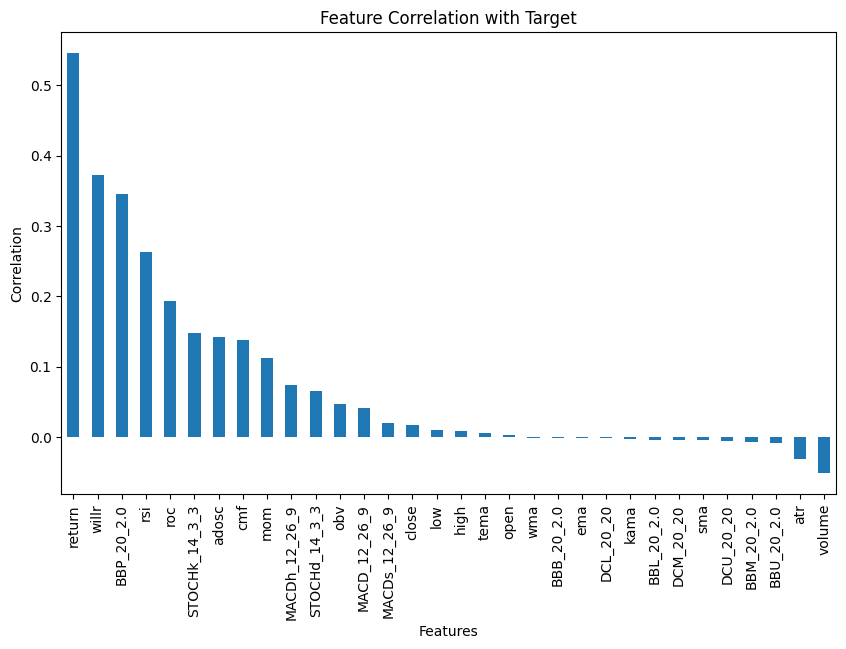

target
1    0.528106
0    0.471894
Name: proportion, dtype: float64


In [ ]:
print(data.info())
print(data.describe())
print(data.isnull().sum())

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation of all features with the target
correlations = data.corr()['target'].sort_values(ascending=False)

# Display top correlations
print("Top correlations with target:")
print(correlations.head(10))

# Plot the top features correlated with the target

plt.figure(figsize=(10, 6))
correlations.drop('target').plot(kind='bar')
plt.title('Feature Correlation with Target')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()


print(data['target'].value_counts(normalize=True))




In [ ]:
# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale features
feature_columns = data.columns.difference(['close'])  # Exclude the target 'close'
data[feature_columns] = feature_scaler.fit_transform(data[feature_columns])

# Scale target
data['close_scaled'] = target_scaler.fit_transform(data[['close']])


I built the LSTM model with keras's sequential model.

I have used LSTM, Dropout and Dense layers.

In [ ]:
# Step 3: Define Features and Target
X = data[feature_columns].values  # Scaled features
y = data['close_scaled'].values  # Scaled target (close price)

# Step 4: Create Sequences for LSTM
window_size = 30  # Sequence length for LSTM

def create_sequences(data, target, window_size):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i + window_size])
        y_seq.append(target[i + window_size])
    return np.array(X_seq), np.array(y_seq)

X_sequences, y_sequences = create_sequences(X, y, window_size)

# Sequential split: Use 80% of the data for training, 20% for testing
train_size = int(len(X_sequences) * 0.8)  # 80% training
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

# Step 5: Build and Train the LSTM Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)  # Linear activation for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,651 (65.04 KB)

 Trainable params: 16,651 (65.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0386 - mae: 0.1339 - val_loss: 0.0014 - val_mae: 0.0205
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0064 - mae: 0.0545 - val_loss: 0.0011 - val_mae: 0.0149
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0041 - mae: 0.0422 - val_loss: 9.4559e-04 - val_mae: 0.0165
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0036 - mae: 0.0401 - val_loss: 9.1508e-04 - val_mae: 0.0160
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0040 - mae: 0.0381 - val_loss: 7.7818e-04 - val_mae: 0.0139
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0032 - mae: 0.0356 - val_loss: 7.9832e-04 - val_mae: 0.0125
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0027 - mae: 0.0305 - val_loss: 6.4503e-04 - val_mae: 0.0106
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - mae: 0.0311 - val_loss: 6.8484e-04 - val_mae: 0.0122
Epoch 9/10
100/100 ━━━━━

I printed the MAE, MSE and R^2 metrics. Plotted the predicted and actual values of the test data together and sperately.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3171e-04 - mae: 0.0091
Test Loss (MSE): 0.0001430654665455222
Test MAE: 0.009539053775370121
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Squared Error (MSE): 0.000143065469342788
Mean Absolute Error (MAE): 0.009539053180884364
R-squared (R2): 0.9322263759550078


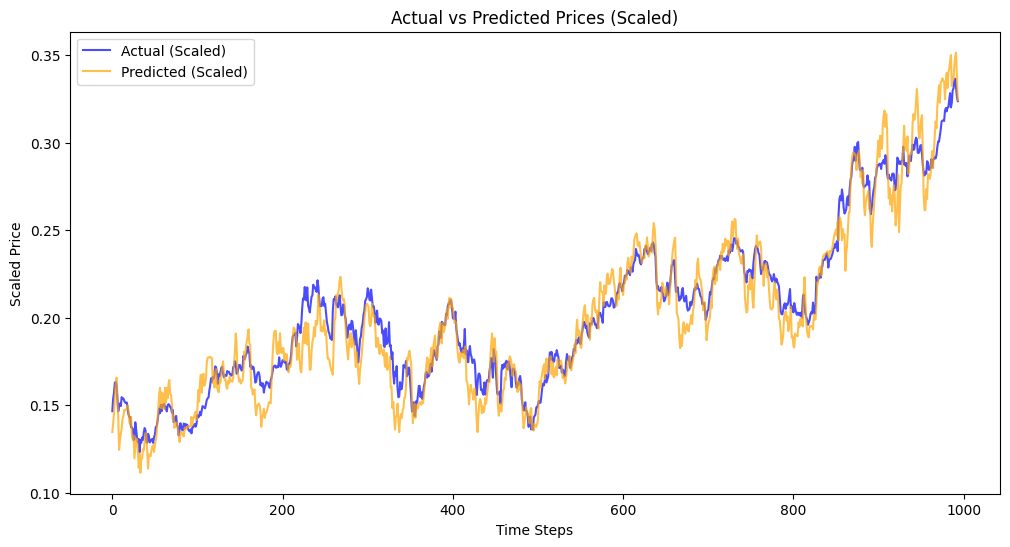

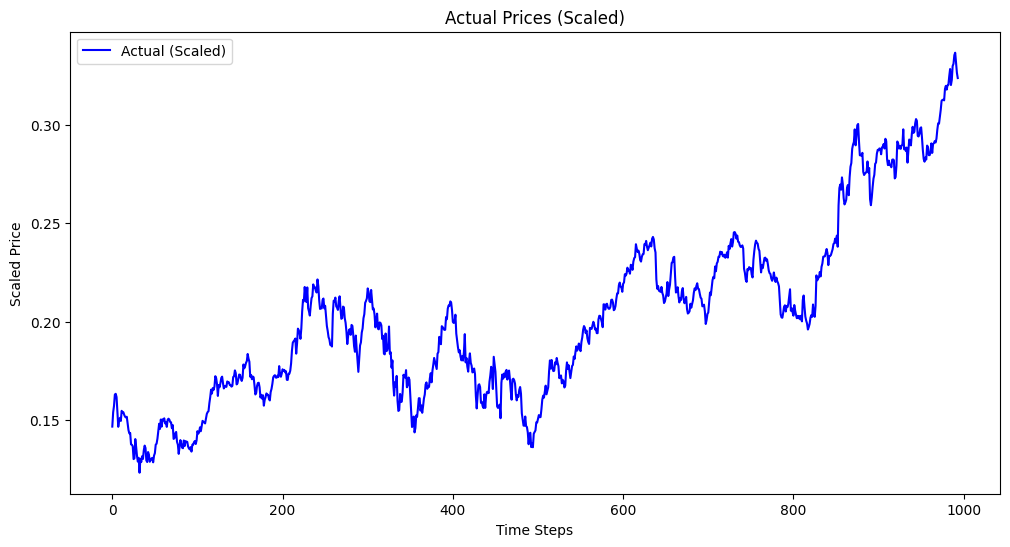

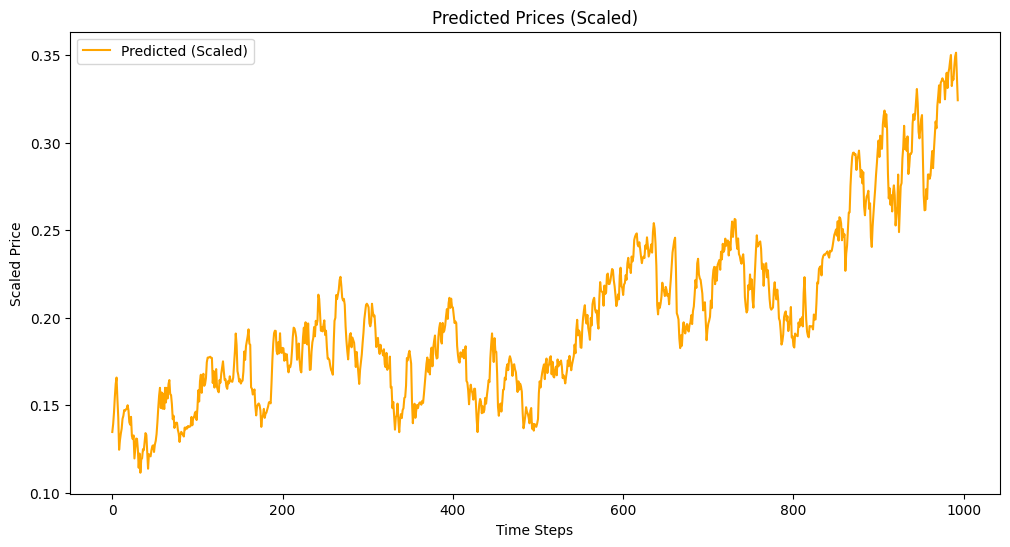

In [ ]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test data
y_pred = model.predict(X_test)

# Evaluation Metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {test_mse}")
print(f"Mean Absolute Error (MAE): {test_mae}")
print(f"R-squared (R2): {test_r2}")

# Plot predicted vs actual (scaled values)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted (Scaled)', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Prices (Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Separate Plots for Clarity
# Plot actual scaled prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue')
plt.title('Actual Prices (Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Plot predicted scaled prices
plt.figure(figsize=(12, 6))
plt.plot(y_pred, label='Predicted (Scaled)', color='orange')
plt.title('Predicted Prices (Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()


Now I move on to the CNN + LSTM structure. I used the architecture mentioned in this paper:

<a href="https://onlinelibrary.wiley.com/doi/10.1155/2020/6622927">A CNN-LSTM-Based Model to Forecast Stock Prices</a><br>
<br>Also printed the MAE, MSE, r^2 results together with the plots of predicted versus actual prices together and seperately on the test set.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,259 (114.29 KB)

 Trainable params: 29,259 (114.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0284 - mae: 0.1108 - val_loss: 0.0021 - val_mae: 0.0183
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0039 - mae: 0.0391 - val_loss: 0.0015 - val_mae: 0.0129
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0034 - mae: 0.0340 - val_loss: 0.0018 - val_mae: 0.0228
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - mae: 0.0337 - val_loss: 0.0012 - val_mae: 0.0127
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0032 - mae: 0.0340 - val_loss: 0.0013 - val_mae: 0.0193
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0030 - mae: 0.0317 - val_loss: 9.9381e-04 - val_mae: 0.0140
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0025 - mae: 0.0321 - val_loss: 8.7190e-04 - val_mae: 0.0127
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023 - mae: 0.0282 - val_loss: 0.0010 - val_mae: 0.0178
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 

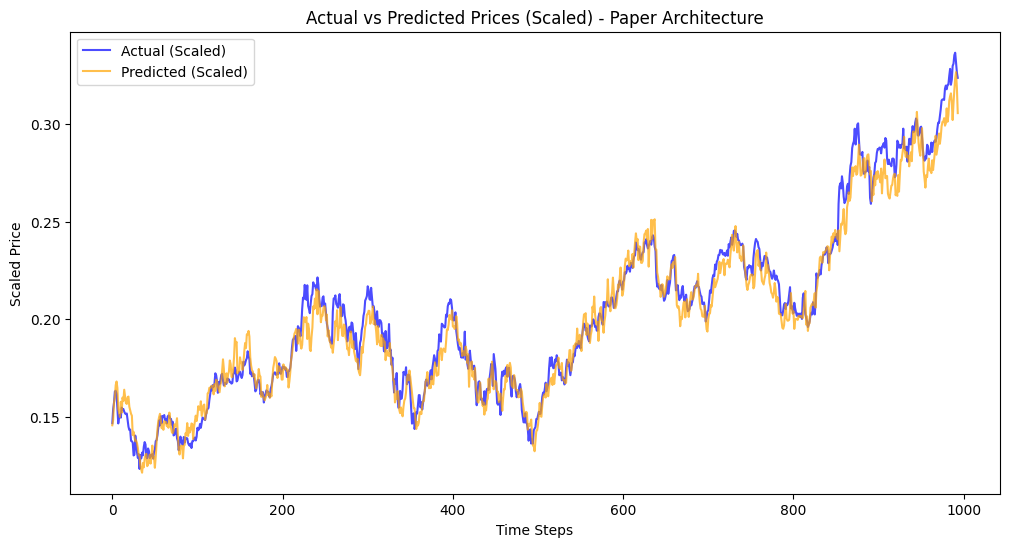

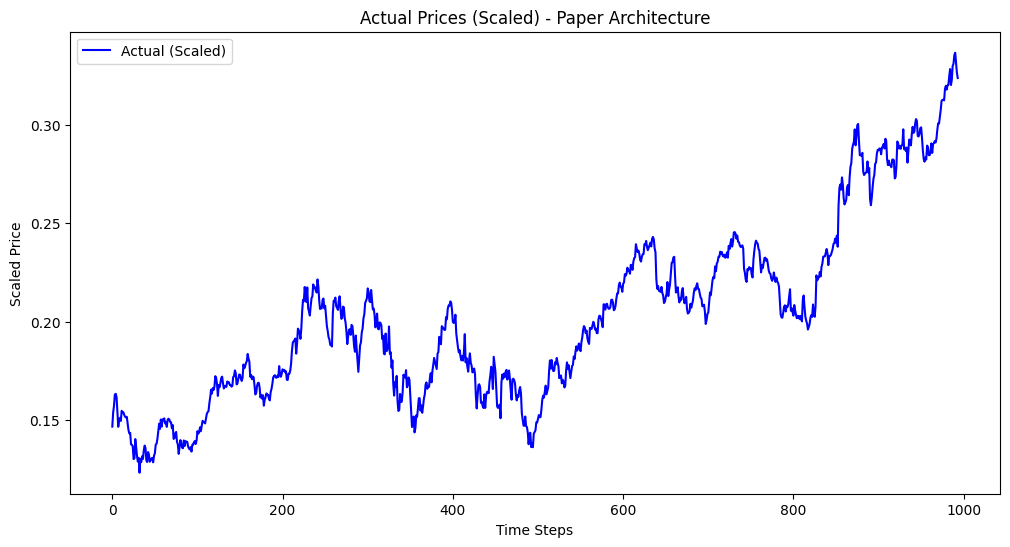

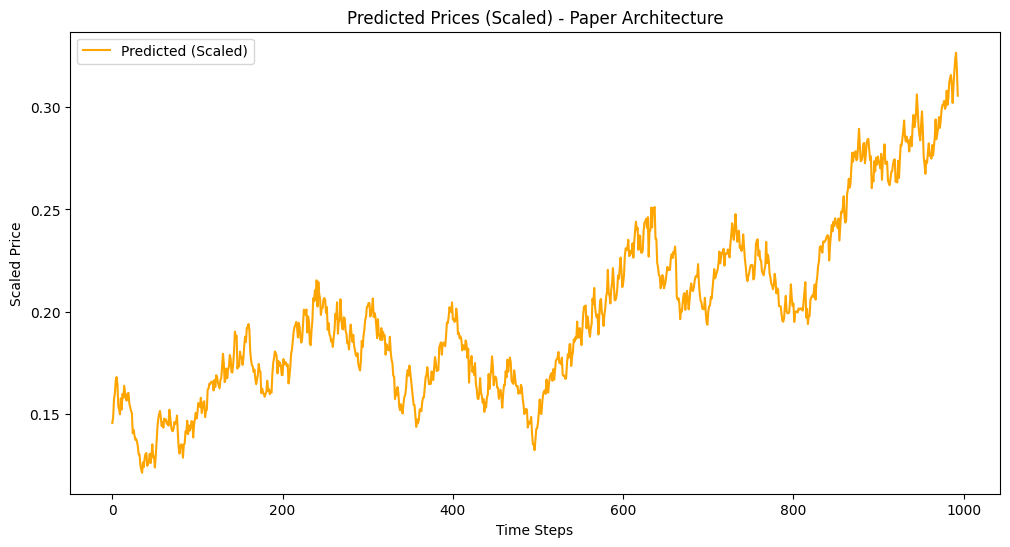

In [ ]:
model = Sequential([
    # CNN layers
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
    MaxPooling1D(pool_size=2),

    # LSTM layer
    LSTM(50, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(1)  # Linear activation for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Step 6: Evaluate and Visualize Results
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test data
y_pred = model.predict(X_test)

# Evaluation Metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {test_mse}")
print(f"Mean Absolute Error (MAE): {test_mae}")
print(f"R-squared (R2): {test_r2}")

# Plot predicted vs actual (scaled values)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted (Scaled)', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Prices (Scaled) - Paper Architecture')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Separate Plots for Clarity
# Plot actual scaled prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue')
plt.title('Actual Prices (Scaled) - Paper Architecture')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

# Plot predicted scaled prices
plt.figure(figsize=(12, 6))
plt.plot(y_pred, label='Predicted (Scaled)', color='orange')
plt.title('Predicted Prices (Scaled) - Paper Architecture')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()


I tried to do backwards elimination for feature selection, but the result is all the features are useful. I believe there might be an issue here but i couldn't figure it out.

In [ ]:
# Function to train and evaluate the model with a given set of features
def train_and_evaluate(X, y, feature_names, window_size=30, verbose=0):
    # Create sequences
    X_sequences, y_sequences = create_sequences(X, y, window_size)
    X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], X_sequences.shape[2]))

    # Sequential split: Use 80% of the data for training, 20% for testing
    train_size = int(len(X_sequences) * 0.8)  # 80% training
    X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
    y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

    # Build the model
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Train the model
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=verbose)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Iterative Feature Elimination
def iterative_feature_elimination(data, target, feature_columns, window_size=30):
    remaining_features = feature_columns.tolist()
    best_mse = float('inf')
    optimal_features = remaining_features[:]
    improvement = True

    while improvement and len(remaining_features) > 1:
        feature_mse = []
        for feature in remaining_features:
            # Remove one feature
            reduced_features = [f for f in remaining_features if f != feature]
            X_reduced = data[reduced_features].values

            # Train and evaluate
            mse = train_and_evaluate(X_reduced, target, reduced_features, window_size)
            feature_mse.append((feature, mse))

        # Find the feature whose removal results in the lowest MSE
        feature_mse.sort(key=lambda x: x[1])
        best_feature, best_feature_mse = feature_mse[0]

        print(f"Removing feature '{best_feature}' resulted in MSE = {best_feature_mse}")

        # Check if removing the feature improves performance
        if best_feature_mse < best_mse:
            best_mse = best_feature_mse
            remaining_features.remove(best_feature)
            optimal_features = remaining_features[:]
        else:
            improvement = False

    print("Optimal feature set:", optimal_features)
    print("Best MSE achieved:", best_mse)
    return optimal_features

# Run the iterative feature elimination
optimal_features = iterative_feature_elimination(data, y, feature_columns)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Removing feature 'willr' resulted in MSE = 0.00010036772630291413


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Removing feature 'adosc' resulted in MSE = 0.00012427245478357344
Optimal feature set: ['BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHd_14_3_3', 'STOCHk_14_3_3', 'adosc', 'atr', 'cmf', 'ema', 'high', 'kama', 'low', 'mom', 'obv', 'open', 'return', 'roc', 'rsi', 'sma', 'target', 'tema', 'volume', 'wma']
Best MSE achieved: 0.00010036772630291413


The target column is a remedy from when i was trying to predict the binary value of if the close price increased or not. However this result shows us that removing it improves model performance. Let's finalize the features of the model.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_64 (Conv1D)                   │ (None, 28, 64)              │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_64 (MaxPooling1D)      │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_66 (LSTM)                       │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,683 (112.04 KB)

 Trainable params: 28,683 (112.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0442 - mae: 0.1285 - val_loss: 0.0041 - val_mae: 0.0438
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0065 - mae: 0.0516 - val_loss: 0.0024 - val_mae: 0.0243
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0047 - mae: 0.0431 - val_loss: 0.0015 - val_mae: 0.0153
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0047 - mae: 0.0418 - val_loss: 0.0015 - val_mae: 0.0190
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0038 - mae: 0.0373 - val_loss: 0.0014 - val_mae: 0.0152
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0033 - mae: 0.0346 - val_loss: 0.0013 - val_mae: 0.0194
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0034 - mae: 0.0335 - val_loss: 9.3485e-04 - val_mae: 0.0135
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - mae: 0.0340 - val_loss: 8.3707e-04 - val_mae: 0.0129
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 

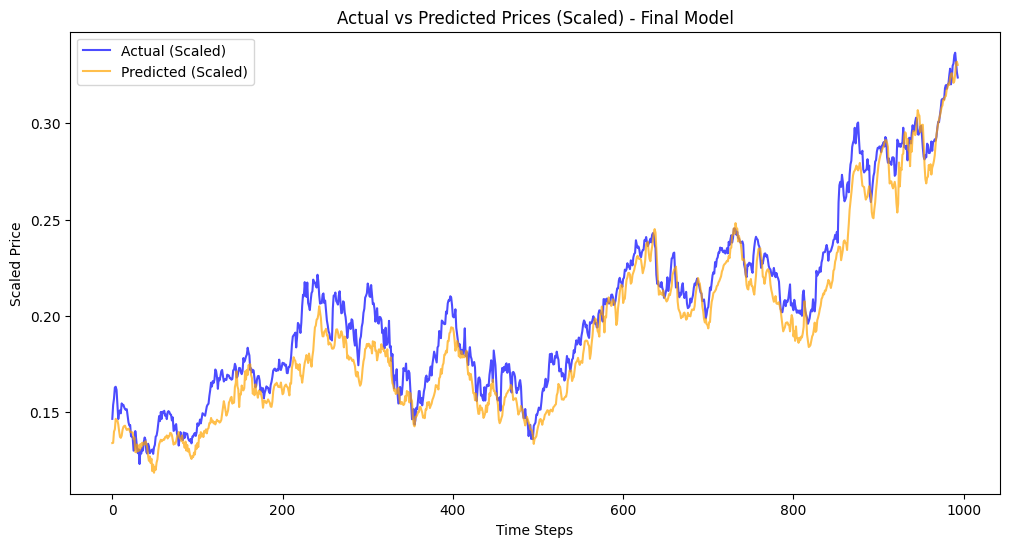

In [ ]:
# Use the optimal feature set
optimal_features = [
    'BBB_20_2.0', 'BBL_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'DCL_20_20',
    'DCM_20_20', 'DCU_20_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'STOCHd_14_3_3', 'STOCHk_14_3_3', 'adosc', 'atr', 'cmf', 'ema', 'high', 'kama',
    'low', 'mom', 'obv', 'open', 'return', 'roc', 'rsi', 'sma', 'tema', 'volume', 'willr'
]

# Prepare data with the optimal feature set
X = data[optimal_features].values
y = data['close_scaled'].values  # Scaled target

# Create sequences
X_sequences, y_sequences = create_sequences(X, y, window_size=30)

# Reshape for CNN input
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], X_sequences.shape[2]))

# Sequential split: Use 80% of the data for training, 20% for testing
train_size = int(len(X_sequences) * 0.8)  # 80% training
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

# Build and train the model
final_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

final_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
final_model.summary()

history = final_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
test_loss, test_mae = final_model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test data
y_pred = final_model.predict(X_test)

# Metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {test_mse}")
print(f"Mean Absolute Error (MAE): {test_mae}")
print(f"R-squared (R2): {test_r2}")

# Plot actual vs predicted prices (scaled)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted (Scaled)', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Prices (Scaled) - Final Model')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()


I used random search for optimizing the parameters listed on the param_grid dictionary.

In [ ]:
from tensorflow.keras.optimizers import Adam
import random

# Define the search space
param_grid = {
    "filters": [32, 64, 128],
    "kernel_size": [2, 3, 5],
    "pool_size": [2, 3],
    "lstm_units": [50, 100, 150],
    "dropout": [0.2, 0.3, 0.4],
    "batch_size": [16, 32, 64],
    "learning_rate": [0.001, 0.01],
    "epochs": [10, 20]
}

# Random search function
def random_search(param_grid, iterations=10):
    best_params = None
    best_mse = float('inf')

    for i in range(iterations):
        # Randomly sample hyperparameters
        params = {k: random.choice(v) for k, v in param_grid.items()}

        # Build the model with sampled hyperparameters
        model = Sequential([
            Conv1D(filters=params["filters"], kernel_size=params["kernel_size"], activation='relu',
                   input_shape=(30, X_train.shape[2])),
            MaxPooling1D(pool_size=params["pool_size"]),
            LSTM(params["lstm_units"], activation='relu'),
            Dropout(params["dropout"]),
            Dense(1)
        ])

        # Compile the model
        optimizer = Adam(learning_rate=params["learning_rate"])
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            validation_split=0.2,
            verbose=0
        )

        # Evaluate on the test set
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        # Track the best parameters
        if mse < best_mse:
            best_mse = mse
            best_params = params

        print(f"Iteration {i + 1}: MSE = {mse} with params = {params}")

    print(f"Best MSE: {best_mse} with params = {best_params}")
    return best_params

# Run random search
best_hyperparams = random_search(param_grid, iterations=10)
print("Optimal Hyperparameters:", best_hyperparams)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Iteration 1: MSE = 0.00036256587826202156 with params = {'filters': 128, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 100, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.001, 'epochs': 20}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Iteration 2: MSE = 6.104727256968335e-05 with params = {'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 100, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 20}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Iteration 3: MSE = 0.0002499971572818356 with params = {'filters': 32, 'kernel_size': 5, 'pool_size': 2, 'lstm_units': 150, 'dropout': 0.4, 'batch_size': 16, 'learning_rate': 0.001, 'epochs': 10}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 4: MSE = 0.0005761259141440467 with params = {'filters': 32, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 50, 'dropout': 0.4, 'batch_size': 64, 'learning_rate': 0.001, 'epochs': 20}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Iteration 5: MSE = 0.0001837943332119303 with params = {'filters': 128, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 50, 'dropout': 0.2, 'batch_size': 64, 'learning_rate': 0.01, 'epochs': 10}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Iteration 6: MSE = 0.00013407926731399202 with params = {'filters': 128, 'kernel_size': 5, 'pool_size': 3, 'lstm_units': 150, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.001, 'epochs': 10}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Iteration 7: MSE = 0.0006628209342305014 with params = {'filters': 32, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 150, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.01, 'epochs': 20}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Iteration 8: MSE = 0.000870302403303558 with params = {'filters': 64, 'kernel_size': 5, 'pool_size': 2, 'lstm_units': 100, 'dropout': 0.4, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 20}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 9: MSE = 0.00010040936757348567 with params = {'filters': 32, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 100, 'dropout': 0.2, 'batch_size': 64, 'learning_rate': 0.01, 'epochs': 20}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Iteration 10: MSE = 0.0005349743042894781 with params = {'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 150, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 10}
Best MSE: 6.104727256968335e-05 with params = {'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 100, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 20}
Optimal Hyperparameters: {'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 100, 'dropout': 0.3, 'batch_size': 32, 'learning_rate': 0.001, 'epochs': 20}


Train the model one last time with optimal hyperparameters and features according to our results. Display the metrics and the plots too.

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0457 - mae: 0.1332 - val_loss: 0.0016 - val_mae: 0.0169
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0048 - mae: 0.0425 - val_loss: 0.0015 - val_mae: 0.0245
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0034 - mae: 0.0357 - val_loss: 0.0012 - val_mae: 0.0185
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030 - mae: 0.0337 - val_loss: 9.4100e-04 - val_mae: 0.0149
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0034 - mae: 0.0331 - val_loss: 9.9487e-04 - val_mae: 0.0176
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0027 - mae: 0.0307 - val_loss: 0.0010 - val_mae: 0.0211
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0027 - mae: 0.0313 - val_loss: 7.6718e-04 - val_mae: 0.0150
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0026 - mae: 0.0305 - val_loss: 7.2996e-04 - val_mae: 0.0160
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 

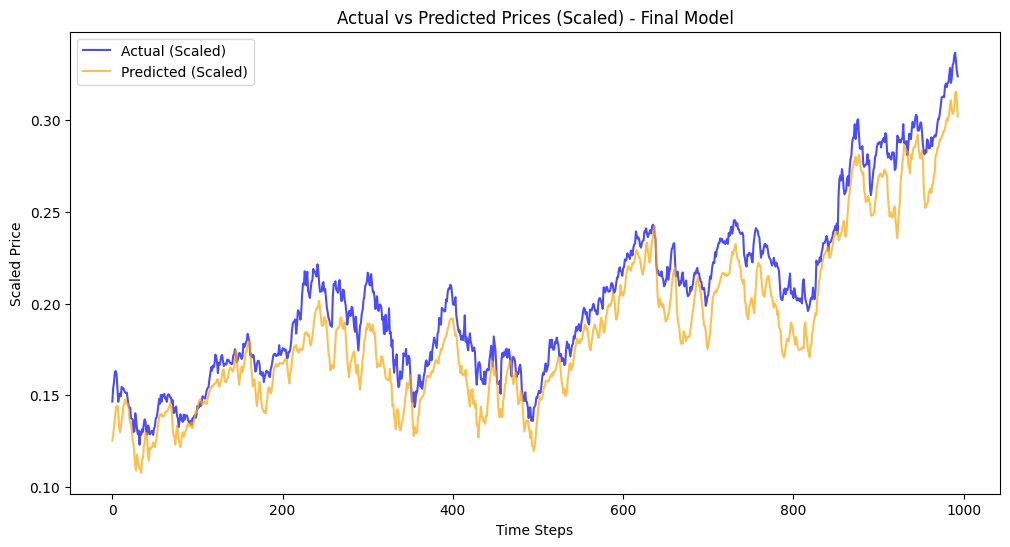

In [ ]:
from tensorflow.keras.optimizers import Adam
import random

# Build the final model with optimal hyperparameters
final_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(100, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile the model with optimal learning rate
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model with optimal batch size and epochs
final_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = final_model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test data
y_pred = final_model.predict(X_test)

# Calculate metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Final Model - MSE: {test_mse}")
print(f"Final Model - MAE: {test_mae}")
print(f"Final Model - R2: {test_r2}")

# Plot actual vs predicted prices (scaled)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (Scaled)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted (Scaled)', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Prices (Scaled) - Final Model')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()
